# Partially denoise items in test set

To get a better sense of how we do on different length structures, we take test set items, and ask our model to denoise partially noised versions of them. We can then compare overall reconstruction error as a function of length.

In [87]:
import os, sys
import multiprocessing as mp
import tempfile
from pathlib import Path
from typing import *

from tqdm.auto import tqdm

from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import pandas as pd
import torch
from torch import nn
from torch.utils.data import default_collate
from huggingface_hub import snapshot_download

from foldingdiff import sampling, modelling, tmalign, utils
from foldingdiff import angles_and_coords as ac

sys.path.append("/home/wukevin/projects/protdiff/bin")
from sample import build_datasets

PLOT_DIR = (Path(os.getcwd()) / '../plots').resolve()
assert PLOT_DIR.is_dir()
PLOT_DIR

PosixPath('/home/wukevin/projects/protdiff/plots')

In [2]:
model_path = Path(snapshot_download("wukevin/foldingdiff_cath"))
model = modelling.BertForDiffusion.from_dir(model_path).to(torch.device('cuda:3'))
model_path

Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Using time embedding: GaussianFourierProjection()
Using loss: [functools.partial(<function radian_smooth_l1_loss at 0x7f7650d6fca0>, beta=0.3141592653589793), functools.partial(<function radian_smooth_l1_loss at 0x7f7650d6fca0>, beta=0.3141592653589793), functools.partial(<function radian_smooth_l1_loss at 0x7f7650d6fca0>, beta=0.3141592653589793), functools.partial(<function radian_smooth_l1_loss at 0x7f7650d6fca0>, beta=0.3141592653589793), functools.partial(<function radian_smooth_l1_loss at 0x7f7650d6fca0>, beta=0.3141592653589793), functools.partial(<function radian_smooth_l1_loss at 0x7f7650d6fca0>, beta=0.3141592653589793)]


PosixPath('/home/wukevin/.cache/huggingface/hub/models--wukevin--foldingdiff_cath/snapshots/98d77b1e68468db5ca03cdba1c0a90f2a2a33edc')

In [3]:
train_dset, valid_dset, test_dset = build_datasets(model_path, load_actual=True)
len(train_dset), len(valid_dset), len(test_dset)

(24316, 3039, 3040)

In [4]:
train_dset.dset.get_masked_means()

array([-1.4702034,  0.0361131,  3.1276708,  1.9405054,  2.0354161,
        2.1225433], dtype=float32)

In [117]:
def compare_angles(reconst_angles, truth_angles) -> float:
    """Return TMscore for structures specified by reconstructed/truth angles."""
    with tempfile.TemporaryDirectory() as tmpdir:
        # Create a PDB file with the reconstructed coordinates
        reconst_path = Path(tmpdir) / "reconst.pdb"
        assert not reconst_path.is_file()
        reconst_pdb = ac.create_new_chain_nerf(str(reconst_path), reconst_angles)

        truth_path = Path(tmpdir) / "truth.pdb"
        assert not truth_path.is_file()
        truth_path = ac.create_new_chain_nerf(str(truth_path), truth_angles)

        # Calculate wrt the truth angles
        score = tmalign.run_tmalign(reconst_pdb, truth_path)
    return score

@torch.no_grad()
def get_reconstruction_error(
    model: nn.Module,
    dset = test_dset,
    noise_timesteps: int = 500,
    bs: int = 512,
    coord_as_truth: bool = False,  # Use raw coordinate version of truth instead of angles version
) -> np.ndarray:
    """
    Get the reconstruction error when adding <noise_timesteps> noise to the idx-th
    item in the dataset.
    """
    device = next(model.parameters()).device
    model.eval()

    recont_angle_sets = []
    truth_angle_sets = []
    truth_pdb_files = []
    for idx_batch in tqdm(utils.seq_to_groups(list(range(len(dset))), bs), desc=f"Diffusion w/ T={noise_timesteps} noise"):
        batch = default_collate(
            [
                {k: v.to(device) for k, v in dset.__getitem__(idx, use_t_val=noise_timesteps).items()} 
                for idx in idx_batch
            ]
        )
        img = batch['corrupted'].clone()
        assert img.ndim == 3

        # Record the actual files containing raw coordinates
        for i in idx_batch:
            truth_pdb_files.append(dset.filenames[i])

        # Run the diffusion model for noise_timesteps steps
        for i in reversed(range(0, noise_timesteps)):
            img = sampling.p_sample(
                model=model,
                x=img,
                t=torch.full((len(idx_batch),), fill_value=i, dtype=torch.long).to(device),
                seq_lens=batch['lengths'],
                t_index=i,
                betas=dset.alpha_beta_terms['betas'],
            )
            img = utils.modulo_with_wrapped_range(img)

        # Finished reconstruction, subset to lengths and add to running list
        for i, l in enumerate(batch['lengths'].squeeze()):
            recont_angle_sets.append(
                pd.DataFrame(
                    utils.modulo_with_wrapped_range(
                        img[i, :l].cpu().numpy() + train_dset.dset.get_masked_means()
                    ),
                    columns=ac.EXHAUSTIVE_ANGLES,
                )
            )
            truth_angle_sets.append(
                pd.DataFrame(
                    utils.modulo_with_wrapped_range(
                        batch['angles'][i, :l].cpu().numpy() + train_dset.dset.get_masked_means()
                    ),
                    columns=ac.EXHAUSTIVE_ANGLES,
                )
            )

    # Get the reconstruction error as a TM score
    if coord_as_truth:
        raise NotImplementedError
    with mp.Pool(mp.cpu_count()) as pool:
        scores = list(pool.starmap(
            compare_angles, zip(recont_angle_sets, truth_angle_sets)
        ))

    return np.array(scores), truth_angle_sets, recont_angle_sets

test_reconst_tm_scores = {}
test_reconst_angles = {}
for t in [10, 100, 250]:
    tm, truth_angles, reconst = get_reconstruction_error(
        model=model, dset=test_dset, noise_timesteps=t,
    )
    test_reconst_tm_scores[t] = tm
    test_reconst_angles[t] = reconst

Diffusion w/ T=10 noise:   0%|          | 0/6 [00:00<?, ?it/s]

Diffusion w/ T=100 noise:   0%|          | 0/6 [00:00<?, ?it/s]

Diffusion w/ T=250 noise:   0%|          | 0/6 [00:00<?, ?it/s]

In [118]:
test_struc_lengths = np.array([test_dset[i]['lengths'].item() for i in range(len(test_dset))])
test_struc_lengths.shape, test_struc_lengths

((3040,), array([128,  98, 128, ..., 128, 128,  96]))

In [119]:
coarse_bins = np.arange(40, 130 + 1, 20)
test_struc_lengths_coarse = np.digitize(test_struc_lengths, bins=coarse_bins)
test_struc_lengths_coarse

array([5, 3, 5, ..., 5, 5, 3])

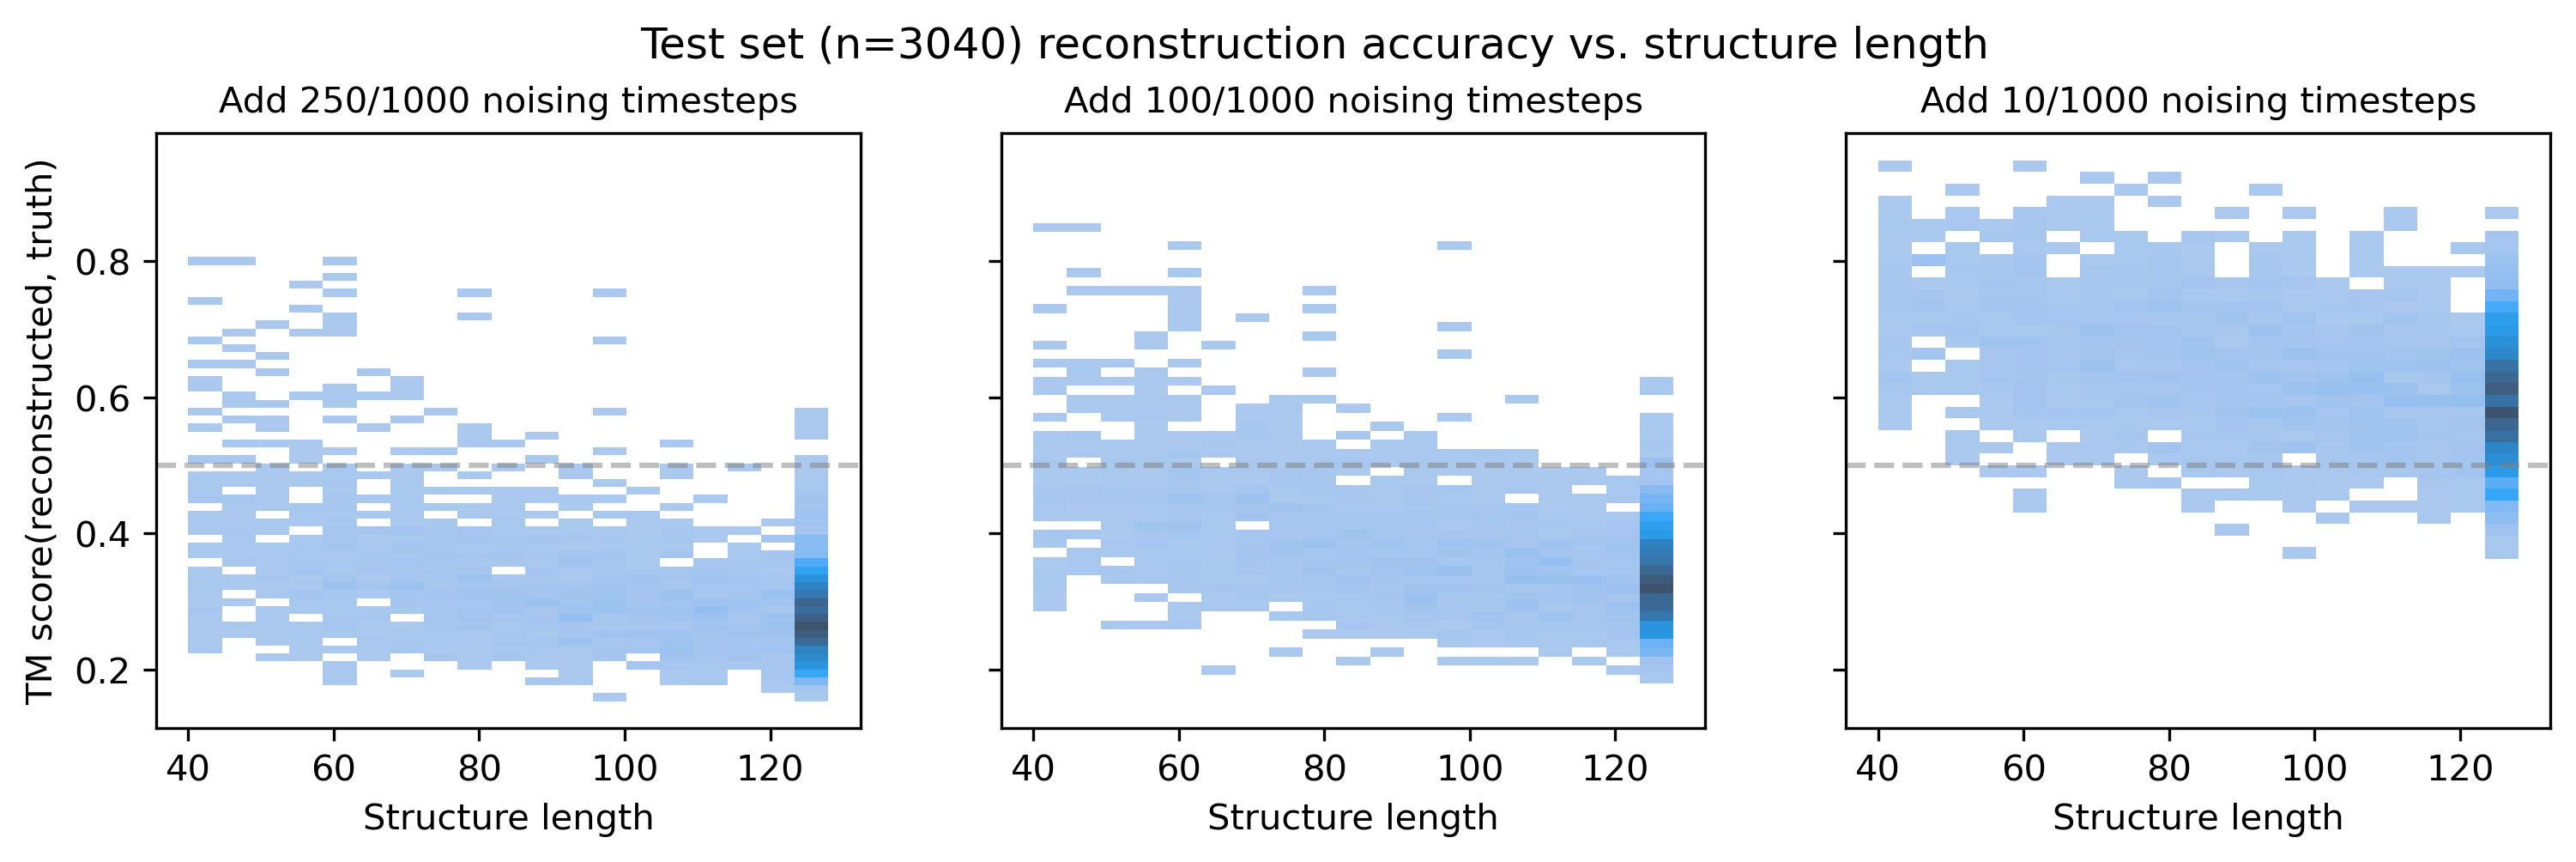

In [120]:
fig, axes = plt.subplots(
    dpi=300,
    ncols=len(test_reconst_tm_scores),
    figsize=(4 * len(test_reconst_tm_scores), 3),
    sharey=True,
)

for t, ax in zip(test_reconst_tm_scores.keys(), axes[::-1]):
    sns.histplot(x=test_struc_lengths, y=test_reconst_tm_scores[t], ax=ax)
    ax.set(
        xlabel="Structure length",
        ylabel="TM score(reconstructed, truth)",
    )
    ax.set_title(f"Add {t}/1000 noising timesteps", size=10)
    ax.axhline(0.5, color='tab:grey', linestyle='dashed', alpha=0.5)

fig.suptitle(
    f"Test set (n={len(next(iter(test_reconst_tm_scores.values())))}) reconstruction accuracy vs. structure length",
    y=1.02,
)

fig.savefig(PLOT_DIR / f"test_reconst_vs_length.pdf", bbox_inches='tight')
fig.show()

In [121]:
for t, tmscores in test_reconst_tm_scores.items():
    stat, pval = stats.spearmanr(test_struc_lengths, tmscores)
    print(t, stat, pval)

10 -0.3282479887798217 2.7209560376515335e-77
100 -0.37102395242596203 7.708074843559397e-100
250 -0.369888640227772 3.3997890926273e-99


## Measure the average error per angle

In [122]:
def difference(x, y):
    delta = utils.modulo_with_wrapped_range(x - y)
    return delta

difference(test_reconst_angles[10][0], truth_angles[0]).mean(axis=0)

phi        -0.005086
psi        -0.000501
omega       0.003637
tau        -0.002083
CA:C:1N     0.000094
C:1N:1CA   -0.000605
dtype: float32

In [126]:
delta_mean, delta_std = [], []

for t, reconst in test_reconst_angles.items():
    d = difference(pd.concat(reconst), pd.concat(truth_angles))
    delta_mean.append(d.mean(axis=0))
    delta_std.append(d.std(axis=0))

delta_mean = pd.DataFrame(delta_mean, index=test_reconst_angles.keys())
delta_mean

,phi,psi,omega,tau,CA:C:1N,C:1N:1CA
10,-0.001423,-0.001423,0.001253,-0.000290,0.001097,-0.000157
100,-0.001928,-0.005122,0.008685,-0.000402,0.003725,0.000983
250,0.002905,-0.009807,0.009512,-0.000435,0.002994,-0.000519


In [127]:
delta_std = pd.DataFrame(delta_std, index=test_reconst_angles.keys())
delta_std

,phi,psi,omega,tau,CA:C:1N,C:1N:1CA
10,0.040672,0.040957,0.046369,0.027502,0.017327,0.022324
100,0.179563,0.182659,0.198521,0.049077,0.030160,0.037408
250,0.351281,0.353573,0.261992,0.055109,0.052059,0.056734
